In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense, Reshape, RepeatVector, Dropout
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras.constraints import unit_norm, max_norm

from scipy import stats
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import argparse
import os
from sklearn.manifold import MDS
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score

/Users/wuzhejun/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from mpl_toolkits.mplot3d import Axes3D

# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    thre = K.random_uniform(shape=(batch,1))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [4]:
# Load Toy Example Data
training_feature = np.loadtxt('X.txt')
training_feature.shape

Y = np.loadtxt('Y.txt')
ground_truth_r = Y

np.random.seed(seed=0)

original_dim = training_feature.shape[1]
num_train = training_feature.shape[0]

In [5]:
## Build VAE-Regression Model
input_shape_x = (original_dim, )
input_shape_r = (1, )

intermediate_dim = 32
batch_size = 64
latent_dim = 8
epochs = 100

# VAE model = encoder + decoder
# build encoder model
inputs_r = Input(shape=input_shape_r, name='ground_truth')
inputs_x = Input(shape=input_shape_x, name='encoder_input')
inputs_x_dropout = Dropout(0.25)(inputs_x)

inter_x1 = Dense(128, activation='tanh', name='encoder_intermediate')(inputs_x_dropout)
inter_x2 = Dense(intermediate_dim, activation='tanh', name='encoder_intermediate_2')(inter_x1)

# posterior on Y; probablistic regressor
r_mean = Dense(1, name='r_mean')(inter_x2)
r_log_var = Dense(1, name='r_log_var')(inter_x2)

# q(z|x)
z_mean = Dense(latent_dim, name='z_mean')(inter_x2)
z_log_var = Dense(latent_dim, name='z_log_var')(inter_x2)

# use reparameterization trick to push the sampling out as input
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
r = Lambda(sampling, output_shape=(1,), name='r')([r_mean, r_log_var])

# latent generator (simplified)
pz_mean = Dense(latent_dim, name='pz_mean',kernel_constraint=unit_norm())(r)
# pz_log_var = Dense(1, name='pz_log_var')(r)

# instantiate encoder model
encoder = Model([inputs_x,inputs_r], [z_mean, z_log_var, z, r_mean, r_log_var, r, pz_mean], name='encoder')
encoder.summary()

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
inter_y1 = Dense(intermediate_dim, activation='tanh')(latent_inputs)
inter_y2 = Dense(128, activation='tanh')(inter_y1)
outputs = Dense(original_dim)(inter_y2)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder([inputs_x,inputs_r])[2])
vae = Model([inputs_x,inputs_r], outputs, name='vae_mlp')
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 301)          0                                            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 301)          0           encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_intermediate (Dense)    (None, 128)          38656       dropout_1[0][0]                  
__________________________________________________________________________________________________
encoder_intermediate_2 (Dense)  (None, 32)           4128        encoder_intermediate[0][0]       
__________________________________________________________________________________________________
r_mean (De

In [6]:
##Customize Lost Function of the VAE Model
models = (encoder, decoder)

#reconstruction_loss = K.tf.divide(0.5*K.sum(K.square(inputs_x-outputs), axis=-1), K.exp(outputs_var)) + 0.5*original_dim*outputs_var
reconstruction_loss = mse(inputs_x,outputs)
#kl_loss = 1 + z_log_var - pz_log_var - K.tf.divide(K.square(z_mean-pz_mean),K.exp(pz_log_var)) - K.tf.divide(K.exp(z_log_var),K.exp(pz_log_var))
kl_loss = 1 + z_log_var - K.square(z_mean-pz_mean) - K.exp(z_log_var)
kl_loss = -0.5*K.sum(kl_loss, axis=-1)
label_loss = K.tf.divide(0.5*K.square(r_mean - inputs_r), K.exp(r_log_var)) +  0.5 * r_log_var

vae_loss = K.mean(reconstruction_loss+kl_loss+label_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()
vae.save_weights('random_weights.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 301)          0                                            
__________________________________________________________________________________________________
ground_truth (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 8), (None, 8 43394       encoder_input[0][0]              
                                                                 ground_truth[0][0]               
__________________________________________________________________________________________________
decoder (Model)                 (None, 301)          43341       encoder[1][2]                    
Total para

In [7]:
## Train the network
np.random.seed(0)
skf = StratifiedKFold(n_splits=10)
pred = np.zeros((ground_truth_r.shape))
fake = np.zeros((ground_truth_r.shape[0]))
fake[:300] = 1

# Run 5-fold CV
for train_idx, test_idx in skf.split(training_feature,fake):
    training_feature_sk = training_feature[train_idx,:]
    training_score = ground_truth_r[train_idx]
    
    testing_feature_sk = training_feature[test_idx,:]
    testing_score = ground_truth_r[test_idx]    
    
    vae.load_weights('random_weights.h5')
    vae.fit([training_feature_sk,training_score],
             epochs=epochs,
             batch_size=batch_size,
             verbose = 0)
    
    [z_mean, z_log_var, z, r_mean, r_log_var, r_vae, pz_mean] = encoder.predict([testing_feature_sk,testing_score],batch_size=batch_size)
    pred[test_idx] = r_mean[:,0]
    

Mean squared error: 0.358
R2 Variance score: 0.641


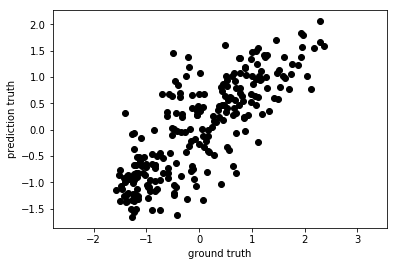

In [8]:
## Validation
# The mean squared error
print("Mean squared error: %.3f" % mean_squared_error(ground_truth_r, pred))
# Explained variance score: 1 is perfect prediction
print('R2 Variance score: %.3f' % r2_score(ground_truth_r, pred))

# Plot Prediction vs. Ground-truth Y
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(ground_truth_r, pred,  color='black')
plt.xlabel('ground truth')
plt.ylabel('prediction truth')
ax.axis('equal');

(-4.876583864295159,
 6.274853986551141,
 -0.8972894163755847,
 0.9186161641912578)

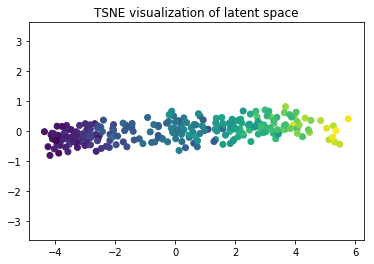

In [9]:
## Visualize Latent Space
vae.load_weights('random_weights.h5')
vae.fit([training_feature,ground_truth_r],
         epochs=epochs,
         batch_size=batch_size,
         verbose = 0)
 
[z_mean, z_log_var, z, r_mean, r_log_var, r_vae, pz_mean] = encoder.predict([training_feature,ground_truth_r],batch_size=batch_size)

tsne = MDS(n_components=2, random_state=0)
X_2d = tsne.fit_transform(z_mean)

#%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X_2d[:, 0], X_2d[:, 1], c=ground_truth_r)
plt.title('TSNE visualization of latent space')
ax.axis('equal')
